# Random Forest on Yearly Aggregates
<a id='top'></a>

<a href=#readdata>Read Data</a>  

<a href=#features>Feature Selection</a>

<a href=#dt>Random Forest</a>

<a href=#inspectfeatures>Inspect Features</a>

<a href=#dummy>One Hot Encode</a>

<a href=#balancedata>Balance Data</a>

<a href=#dt_rebalance>Random Forest on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#verify_unbalanced>Verify on Unbalanced Dataset</a>

<a href=#re_train>Re-Train Optimal Tree on Unbalanced data</a>

<a href=#feature_importance_final>Feature Importance on Final Model</a>

<a href=#bottom>Bottom</a>


## Questions:

has_relocated_this_year

has_relocated_next_year has null values

reading in directly from bucket



In [1]:
# Ignore 'dask' warning
import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
from datetime import date
import numpy as np

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import sem
import pickle


from matplotlib import pyplot
import seaborn as sns
from scipy import stats

<a id='readdata'></a>
# Read Yearly Aggregated Data 
<a href=#top>Top</a>

In [2]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)


In [3]:
# Post-aggregation
def create_dict_types_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    dtype={ 
        'id_company'  :np.float64,
        'id_branch'    :np.int64, 
        'code_sbi_2'         : np.float64, 
        'has_relocated':bool,
        'has_relocated_next_year ' : bool,
        'has_name_change' : bool,
        'qty_address_mutations_total' :np.float64,
        'ratio_operating_result_consolidated_operating_result': np.float64,
        'ratio_revenue_consolidated_revenue': np.float64,
        'qty_green_flags'   :np.float64,
        'qty_orange_flags'   :np.float64,
        'qty_red_flags'   :np.float64,
        'A'   :np.float64,
        'AA'   :np.float64,
        'AAA'   :np.float64,
        'B'   :np.float64,
        'BB'   :np.float64,
        'BBB'   :np.float64,
        'C'   :np.float64,
        'CC'   :np.float64,
        'CCC'   :np.float64,
        'D'   :np.float64,
        'NR'   :np.float64,
        'code_legal_form_group_1':  np.int64,
        'code_legal_form_group_2':  np.int64,
        'SBI_group_1':  np.int64,
        'SBI_group_2':  np.int64,
        'company_age'   :np.float64,
        'years_since_last_amt_consolidated_operating_result'   :np.float64,
        'years_since_last_amt_consolidated_revenue'   :np.float64,
        'years_since_last_amt_operating_result'   :np.float64,
        'years_since_last_qty_employees'   :np.float64,
        'years_since_last_amt_revenue'   :np.float64,
        'delta_qty_employees'   :np.float64,
        'delta_qty_issued_credit_reports'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'SBI_has_changed' : bool,
        'unique_id' : object,
        'code_legal_form_has_changed ' : bool,
        'is_discontinued_any ' : bool,
        'has_financial_calamity ' : bool,
        'mean_amt_consolidated_operating_result'   :np.float64,
        'mean_amt_consolidated_revenue'   :np.float64,
        'mean_amt_operating_result'   :np.float64,
        'mean_amt_revenue'   :np.float64,
        'mean_qty_employees'   :np.float64,
        'mean_qty_issued_credit_reports'   :np.float64,
        'mean_score_payment_assessment'   :np.float64,
        'mean_score_pd'   :np.float64,
        'qty_address_mutations_year'   :np.float64,
        'qty_started_names_year'   :np.float64,
        'qty_stopped_names_year'   :np.float64,
        'qty_board_changes_year'   :np.float64,
        'variance_qty_employees'   :np.float64,
        'variance_qty_issued_credit_reports'   :np.float64,
        'variance_score_payment_assessment'   :np.float64,
        'variance_score_pd'   :np.float64
      }
    return dtype

def create_parse_dates_list_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    parse_dates= ['date_month', 'years_in_current_location']
    return parse_dates

def create_basetable(year_list, dir_prefix = ''):
    """ Reads a whole year of data from the already aggregated files and creates basetable """
    dtype = create_dict_types_aggregated_data()
    parse_dates = create_parse_dates_list_aggregated_data()
    basetable = pd.DataFrame()
    for year in year_list:
        full_year_df = pd.DataFrame()
        print('Starting with year: ', year)
        print(dir_prefix)
        blob_list = list(bucket.list_blobs(prefix=dir_prefix))    
        for blob in blob_list:  
            if year in blob.name:
                print('Processing file: ', blob.name)
                with fs.open('graydon-data/' + blob.name) as f:
                    full_year_df = pd.read_csv(f, sep=',', index_col=0, dtype=dtype, parse_dates=parse_dates 
                                            )   
                print('The number of rows of the year read is far is: ', full_year_df.shape[0])
        basetable = basetable.append(full_year_df)
    print('The final number of rows of the basetable created is: ', basetable.shape[0])
    return basetable

# Calling it
data_df = create_basetable(year_list = ['2016'], dir_prefix ='03_aggregated')

Starting with year:  2016
03_aggregated
Processing file:  03_aggregated/2016_aggregated.csv


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The number of rows of the year read is far is:  1930102
The final number of rows of the basetable created is:  1930102


In [5]:
data_df.shape

(1930102, 58)

In [6]:
data_df.columns

Index(['id_branch', 'id_company', 'date_month', 'code_sbi_1', 'has_relocated',
       'has_name_change', 'delta_qty_employees',
       'delta_qty_issued_credit_reports', 'delta_score_payment_assessment',
       'code_legal_form_has_changed', 'SBI_has_changed', 'company_age',
       'years_since_last_amt_consolidated_operating_result',
       'years_since_last_amt_consolidated_revenue',
       'years_since_last_amt_operating_result',
       'years_since_last_qty_employees', 'years_since_last_amt_revenue',
       'years_in_current_location', 'qty_address_mutations_year',
       'qty_started_names_year', 'qty_stopped_names_year',
       'qty_board_changes_year',
       'ratio_operating_result_consolidated_operating_result',
       'ratio_revenue_consolidated_revenue', 'unique_id', 'qty_green_flags',
       'qty_orange_flags', 'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB',
       'C', 'CC', 'CCC', 'D', 'NR', 'code_legal_form_group_1',
       'code_legal_form_group_2', 'SBI_group_1', 

## Check Distribution of Target:

In [7]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    1741379
True      111461
Name: has_relocated_next_year, dtype: int64 
 False    0.902221
True     0.057749
Name: has_relocated_next_year, dtype: float64


In [8]:
sum(data_df.has_relocated_next_year.isna())

77262

In [9]:
data_df[data_df.has_relocated_next_year.isna()] = 0

In [10]:
sum(data_df.has_relocated_next_year.isna())

0

In [11]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    1818641
True      111461
Name: has_relocated_next_year, dtype: int64 
 False    0.942251
True     0.057749
Name: has_relocated_next_year, dtype: float64


In [12]:
HTML(DataFrame(data_df).head(10).to_html())

,id_branch,id_company,date_month,code_sbi_1,has_relocated,has_name_change,delta_qty_employees,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,SBI_has_changed,company_age,years_since_last_amt_consolidated_operating_result,years_since_last_amt_consolidated_revenue,years_since_last_amt_operating_result,years_since_last_qty_employees,years_since_last_amt_revenue,years_in_current_location,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,ratio_operating_result_consolidated_operating_result,ratio_revenue_consolidated_revenue,unique_id,qty_green_flags,qty_orange_flags,qty_red_flags,A,AA,AAA,B,BB,BBB,C,CC,CCC,D,NR,code_legal_form_group_1,code_legal_form_group_2,SBI_group_1,SBI_group_2,is_discontinued_any,has_financial_calamity,mean_amt_consolidated_operating_result,mean_amt_consolidated_revenue,mean_amt_operating_result,mean_amt_revenue,mean_qty_employees,mean_qty_issued_credit_reports,mean_score_payment_assessment,mean_score_pd,variance_qty_employees,variance_qty_issued_credit_reports,variance_score_payment_assessment,variance_score_pd,has_relocated_next_year
0,0,428134.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,36.0,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_428134.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
1,0,803351.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_803351.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
2,0,810695.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_810695.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
3,0,811258.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_811258.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
4,0,811333.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_811333.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
5,0,818258.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_818258.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
6,0,823722.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_823722.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
7,0,829630.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_829630.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
8,0,834432.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_834432.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False
9,0,834909.0,2016-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.0,0.0,0.0,0.0,NaN,NaN,0_834909.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,False


In [13]:
data_df.shape

(1930102, 58)

<a id='features'></a>
# Feature Selection:

<a href=#top>Top</a>

In [14]:
print(data_df.isnull().sum())

id_branch                                                     0
id_company                                                    0
date_month                                                    0
code_sbi_1                                              1848249
has_relocated                                                 0
has_name_change                                               0
delta_qty_employees                                      288185
delta_qty_issued_credit_reports                               0
delta_score_payment_assessment                                0
code_legal_form_has_changed                                   0
SBI_has_changed                                               0
company_age                                               29472
years_since_last_amt_consolidated_operating_result      1800823
years_since_last_amt_consolidated_revenue               1818886
years_since_last_amt_operating_result                   1800823
years_since_last_qty_employees          

In [15]:
features_to_exclude = ('id_branch',
                       'id_company',
                       'date_month',
                       'unique_id',
                       'code_sbi_1',
                       'has_relocated',
                       #'has_name_change',
                       'delta_qty_employees',
                       #'delta_qty_issued_credit_reports', 
                       #'delta_score_payment_assessment',
                       #'code_legal_form_has_changed',
                       #'SBI_has_changed',
                       #'company_age',
                       'years_since_last_amt_consolidated_operating_result',
                       'years_since_last_amt_consolidated_revenue',
                       'years_since_last_amt_operating_result',
                       'years_since_last_qty_employees',
                       'years_since_last_amt_revenue',
                       'years_in_current_location',
                       'ratio_operating_result_consolidated_operating_result',
                       'ratio_revenue_consolidated_revenue',
                       #'qty_green_flags',
                       #'qty_orange_flags',
                       #'qty_red_flags',
                       #'A',
                       #'AA',
                       #'AAA',
                       #'B',
                       #'BB',
                       #'BBB',
                       #'C',
                       #'CC',
                       #'CCC',
                       #'D',
                       #'NR',
                       #'code_legal_form_group_1',
                       #'code_legal_form_group_2',
                       #'SBI_group_1',
                       #'SBI_group_2',
                       #'is_discontinued_any',
                       #'has_financial_calamity',
                       'mean_amt_consolidated_operating_result',
                       'mean_amt_consolidated_revenue',
                       'mean_amt_operating_result',
                       'mean_amt_revenue',
                       'mean_qty_employees',
                       #'mean_qty_issued_credit_reports',
                       #'mean_score_payment_assessment',
                       'mean_score_pd',
                       #'qty_address_mutations_year',
                       #'qty_started_names_year',
                       #'qty_stopped_names_year',
                       #'qty_board_changes_year',
                       'variance_qty_employees',
                       #'variance_qty_issued_credit_reports',
                       #'variance_score_payment_assessment',
                       #'variance_score_pd',
                       'has_relocated_next_year'
                      )

features_in_model = [feature for feature in data_df.columns.tolist() 
                     if feature not in features_to_exclude]


In [16]:
len(features_in_model)

35

In [17]:
features_in_model

['has_name_change',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'code_legal_form_has_changed',
 'SBI_has_changed',
 'company_age',
 'qty_address_mutations_year',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'qty_board_changes_year',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'code_legal_form_group_1',
 'code_legal_form_group_2',
 'SBI_group_1',
 'SBI_group_2',
 'is_discontinued_any',
 'has_financial_calamity',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'variance_qty_issued_credit_reports',
 'variance_score_payment_assessment',
 'variance_score_pd']

In [18]:
data_to_model = data_df[features_in_model + ['has_relocated_next_year']]

In [19]:
data_to_model.shape

(1930102, 36)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [20]:
data_to_model.isnull().values.any()

True

In [21]:
print(data_to_model.isnull().sum())

has_name_change                           0
delta_qty_issued_credit_reports           0
delta_score_payment_assessment            0
code_legal_form_has_changed               0
SBI_has_changed                           0
company_age                           29472
qty_address_mutations_year                0
qty_started_names_year                    0
qty_stopped_names_year                    0
qty_board_changes_year                    0
qty_green_flags                           0
qty_orange_flags                          0
qty_red_flags                             0
A                                         0
AA                                        0
AAA                                       0
B                                         0
BB                                        0
BBB                                       0
C                                         0
CC                                        0
CCC                                       0
D                               

Drop NA rows:

In [22]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(1891748, 36)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
data_to_model.isnull().values.any()

False

<a id='dt'></a>
# Random Forest:

<a href=#top>Top</a>

In [24]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated_next_year, 
                                                    test_size=0.20, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [25]:
x_train.shape

(1513398, 35)

In [26]:
print(y_train.value_counts(), '\n', y_train.value_counts() / y_train.shape[0])

0    1424941
1      88457
Name: has_relocated_next_year, dtype: int64 
 0    0.941551
1    0.058449
Name: has_relocated_next_year, dtype: float64


In [27]:
#clf0 = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0)

#clf0.fit(x_train, y_train)  



clf0 = RandomForestClassifier()

clf0.fit(x_train, y_train)  


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.971 



## Save Model:

In [29]:
filename = 'models/RF_2016_defaults_unbalanced.sav'
pickle.dump(clf0, open(filename, 'wb'))

## Tune Model Parameters

<a href=#top>Top</a>

In [60]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8],
    'criterion' :['gini', 'entropy']
}

clf00 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5, n_jobs=4)
clf00.fit(X=x_train, y=y_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [59]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clf00 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, cv = 3)
clf00.fit(X=x_train, y=y_train)
clf0 = clf00.best_estimator_
print (clf00.best_score_, clf00.best_params_)

0.9519634442998275 {'min_samples_split': 5, 'max_depth': 6}


In [60]:
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.952 



## Accuracy Measures
<a href=#top>Top</a>

In [37]:
clf0

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
y_pred=clf0.predict(x_test)

In [39]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[353087,   3283],
       [ 21452,    528]])

In [40]:
y_pred=clf0.predict(x_test)
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [41]:
score, auc, kappa

(0.9346240253733316, 0.5968287327279418, 0.02419125200180383)

In [42]:
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97    356370
           1       0.14      0.02      0.04     21980

   micro avg       0.93      0.93      0.93    378350
   macro avg       0.54      0.51      0.50    378350
weighted avg       0.90      0.93      0.91    378350



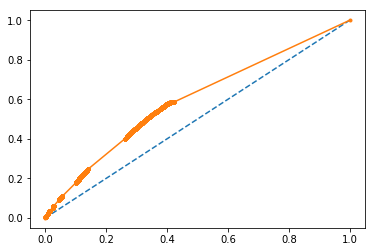

In [43]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance'></a>
# Feature Importance
<a href=#top>Top</a>

NameError: name 'plt' is not defined

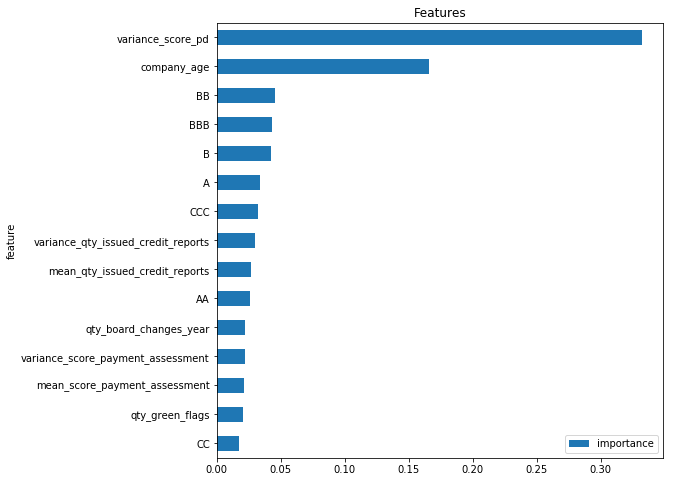

In [44]:
feat_imp = pd.DataFrame({'importance':clf0.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [45]:
train_all = x_train.copy()

In [46]:
train_all.columns

Index(['has_name_change', 'delta_qty_issued_credit_reports',
       'delta_score_payment_assessment', 'code_legal_form_has_changed',
       'SBI_has_changed', 'company_age', 'qty_address_mutations_year',
       'qty_started_names_year', 'qty_stopped_names_year',
       'qty_board_changes_year', 'qty_green_flags', 'qty_orange_flags',
       'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC',
       'D', 'NR', 'code_legal_form_group_1', 'code_legal_form_group_2',
       'SBI_group_1', 'SBI_group_2', 'is_discontinued_any',
       'has_financial_calamity', 'mean_qty_issued_credit_reports',
       'mean_score_payment_assessment', 'variance_qty_issued_credit_reports',
       'variance_score_payment_assessment', 'variance_score_pd'],
      dtype='object')

In [47]:
train_all['has_relocated_next_year'] = y_train

In [48]:
train_all.shape

(1513398, 36)

In [49]:
train_all.has_relocated_next_year.value_counts() / train_all.shape[0]

0    0.941551
1    0.058449
Name: has_relocated_next_year, dtype: float64

In [50]:
# Choose desired class breakdown
fraction_majority = 0.50

In [52]:
num_minority = train_all[train_all['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(88457, 88457, 88457.0, 0.5)

In [53]:
# Separate majority and minority classes
df_majority = train_all[train_all.has_relocated_next_year==False]
df_minority = train_all[train_all.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

1    88457
0    88457
Name: has_relocated_next_year, dtype: int64

In [54]:
df_downsampled.has_relocated_next_year.value_counts()/df_downsampled.shape[0]

1    0.5
0    0.5
Name: has_relocated_next_year, dtype: float64

In [55]:
df_downsampled.shape

(176914, 36)

## Remove NaNs from Balanced Dataset:

In [56]:
data_to_model = df_downsampled

In [57]:
data_to_model.shape

(176914, 36)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [58]:
data_to_model.isnull().values.any()

False

In [118]:
print(data_to_model.isnull().sum())

has_name_change                       0
delta_qty_issued_credit_reports       0
delta_score_payment_assessment        0
code_legal_form_has_changed           0
SBI_has_changed                       0
company_age                           0
qty_green_flags                       0
qty_orange_flags                      0
qty_red_flags                         0
A                                     0
AA                                    0
AAA                                   0
B                                     0
BB                                    0
BBB                                   0
C                                     0
CC                                    0
CCC                                   0
D                                     0
NR                                    0
code_legal_form_group_1               0
code_legal_form_group_2               0
SBI_group_1                           0
SBI_group_2                           0
is_discontinued_any                   0


Drop rows with NA:

In [80]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(180434, 40)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
data_to_model.isnull().values.any()

False

<a id='dt_rebalance'></a>

# Random Forest on Re-balanced data

<a href=#top>Top</a>

In [59]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

y_re_train=y_re_train.astype('int')
y_re_test=y_re_test.astype('int')

In [60]:
x_train.shape

(1513398, 35)

In [61]:
x_re_train.shape

(132685, 35)

In [62]:
# clf = RandomForestClassifier(n_estimators=100, max_depth=6,random_state=0, min_samples_split=5)

# clf.fit(x_re_train, y_re_train)

clf = RandomForestClassifier()

clf.fit(x_re_train, y_re_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
# Train accuracy:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.905 



In [64]:
# Test accuracy:
measure_performance(x_re_test,y_re_test,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.599 



## Save Model

In [65]:
filename = 'models/RF_2016defaults_balanced.sav'
pickle.dump(clf, open(filename, 'wb'))

## Model Tuning:

In [97]:
RandomForestClassifier?

In [160]:
x_train.shape

(4537409, 36)

In [67]:
#parameters = {'n_estimators':range(50,120)}

parameters = {'max_depth':range(15, 25), 'min_samples_leaf':[5, 10, 15], 'min_samples_split':range(5, 10)}

clfB = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=4)
clfB.fit(X=x_re_train, y=y_re_train)
clf_RF = clfB.best_estimator_
print (clfB.best_score_, clfB.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6342842069563251 {'min_samples_leaf': 15, 'min_samples_split': 8, 'max_depth': 15}


In [101]:
#parameters = {'n_estimators':range(50,120)}

parameters = {'n_estimators':[100, 150, 200]}

clfB = GridSearchCV(RandomForestClassifier(min_samples_split=8, min_samples_leaf=15, 
                                          max_depth=15, ), parameters, n_jobs=4)
clfB.fit(X=x_re_train, y=y_re_train)
clf_RF = clfB.best_estimator_
print (clfB.best_score_, clfB.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6370652296793157 {'n_estimators': 150}


In [98]:
clf_RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [99]:
#parameters = {'n_estimators':range(50,120)}

parameters = {'max_depth':range(10, 22), 
              'min_samples_leaf':[11, 15, 20, 25], 
              'min_samples_split':range(8, 20),
             'max_features':[2,5,8,12,15,20]}

clfC = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=4)
clfC.fit(X=x_re_train, y=y_re_train)
clf_RFII = clfC.best_estimator_
print (clfC.best_score_, clfC.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [68]:
filename = 'models/RF_2016md15_msl15_mss8_balanced.sav'
pickle.dump(clf_RF, open(filename, 'wb'))

In [102]:
y_re_pred=clf_RF.predict(x_re_test)
# Get probabilities
y_re_probs = clf_RF.predict_proba(x_re_test)


score=metrics.accuracy_score(y_re_test, y_re_pred)


# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

In [103]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[11017, 10935],
       [ 4863, 17414]])

In [70]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[11111, 10841],
       [ 5100, 17177]])

In [104]:
score, auc, kappa

(0.6428135386285017, 0.6968884357220531, 0.2841441278413228)

In [71]:
score, auc, kappa

(0.6395803658233286, 0.6930017895374053, 0.2777439599698738)

In [72]:
print(cr)

              precision    recall  f1-score   support

           0       0.69      0.51      0.58     21952
           1       0.61      0.77      0.68     22277

   micro avg       0.64      0.64      0.64     44229
   macro avg       0.65      0.64      0.63     44229
weighted avg       0.65      0.64      0.63     44229



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


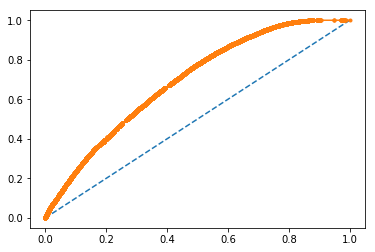

In [73]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<a id='verify_unbalanced'></a>
## Verify on Un-balanced test set:

<a href=#top>Top</a>

In [74]:
y_re_pred_unbalance=clf_RF.predict(x_test)

In [75]:
y_re_pred_unbalance.shape

(378350,)

In [76]:
sum(y_test) / len(y_test), sum(y_test==0) / len(y_test) 

(0.05809435707678076, 0.9419056429232192)

In [77]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.510791595083917, 0.489208404916083)

In [78]:
cnf_matrix = metrics.confusion_matrix(y_test, y_re_pred_unbalance)
cnf_matrix

array([[179954, 176416],
       [  5138,  16842]])

In [79]:
score=metrics.accuracy_score(y_test, y_re_pred_unbalance)

# Get probabilities
y_re_probs = clf_RF.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_test, y_re_pred_unbalance)
cr=metrics.classification_report(y_test, y_re_pred_unbalance)

In [80]:
score, auc, kappa

(0.5201427249900885, 0.6940697311019262, 0.0582497753641642)

In [81]:
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.50      0.66    356370
           1       0.09      0.77      0.16     21980

   micro avg       0.52      0.52      0.52    378350
   macro avg       0.53      0.64      0.41    378350
weighted avg       0.92      0.52      0.64    378350



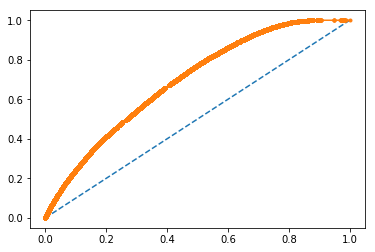

In [82]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<a id='re_train'></a>
# Re-Train Optimal Tree on Unbalanced data 
<a href=#top>Top</a>

In [83]:

#'min_samples_leaf': 15, 'min_samples_split': 8, 'max_depth': 15            
clf1 = RandomForestClassifier(min_samples_leaf=15, min_samples_split=8, max_depth=15)

clf1.fit(x_train, y_train)  


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
measure_performance(x_train,y_train,clf1, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.942 



In [85]:
y_predII=clf1.predict(x_test)

In [86]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predII)
cnf_matrix

array([[356370,      0],
       [ 21980,      0]])

In [87]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf1.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9419


In [88]:
score=metrics.accuracy_score(y_test, y_predII)

# Get probabilities
y_probs = clf1.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [89]:
score, auc, kappa

(0.9419056429232192, 0.6972240286578882, 0.02419125200180383)

In [90]:
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97    356370
           1       0.14      0.02      0.04     21980

   micro avg       0.93      0.93      0.93    378350
   macro avg       0.54      0.51      0.50    378350
weighted avg       0.90      0.93      0.91    378350



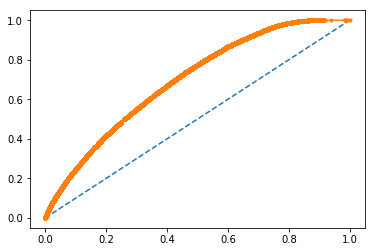

In [91]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill

pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance2'></a>
## Feature Importance
<a href=#top>Top</a>

NameError: name 'plt' is not defined

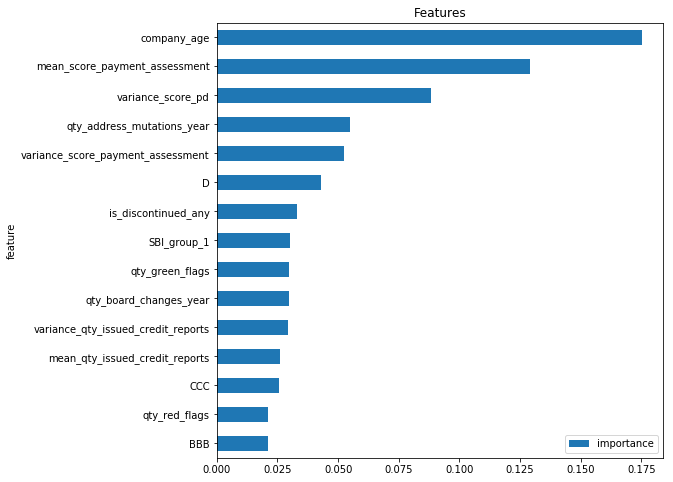

In [92]:
feat_imp = pd.DataFrame({'importance':clf1.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a href=#top>Top</a>
# Feature Importance of Final Model:
<a id='feature_importance_final'></a>

In [94]:
importances = clf_RF.feature_importances_

In [95]:
len(importances)

35

NameError: name 'plt' is not defined

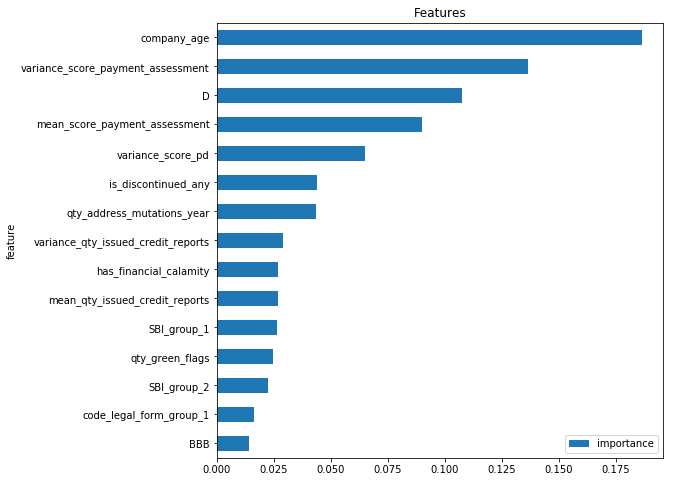

In [96]:

feat_imp = pd.DataFrame({'importance':importances})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a href=#top>Top</a>
# END
<a id='bottom'></a>